# Deep Learning & Art: Neural Style Transfer

This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)


In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [5]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

AttributeError: module 'tensorflow' has no attribute 'Variable'

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

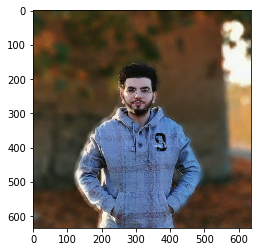

In [3]:
import imageio
content_image = imageio.imread("images/my_content.jpg")
imshow(content_image);

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

** 3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

In [2]:
def compute_content_cost(a_C, a_G):
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.shape
    
    # Reshape a_C and a_G (≈2 lines)
    new_shape = [int(m), int(n_H*n_W), int(n_C)]
    a_C_unrolled = tf.reshape(a_C, new_shape)
    a_G_unrolled = tf.reshape(a_G, new_shape)
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (0.25 / int(n_H*n_W*n_C))*tf.reduce_sum(tf.square(a_G_unrolled - a_C_unrolled))
    return J_content

In [3]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

#### What you should remember
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

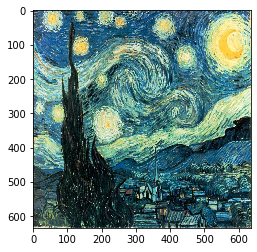

In [6]:
style_image = imageio.imread("images/my_style.jpg")
imshow(style_image);

This was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

Lets see how you can now define a "style" cost function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [7]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 - Style cost

Your goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


In [9]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])
    a_G = tf.transpose(a_G)
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    factor = (.5 / (n_H * n_W * n_C)) ** 2
    J_style_layer = factor * tf.reduce_sum(np.power(GS - GG, 2))

    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190279


### 3.2.3 Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

Lets go through the individual steps in detail. 

#### Interactive Sessions

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. 
* To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". 
* Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  
* This allows you to run variables without constantly needing to refer to the session object (calling "sess.run()"), which simplifies the code.  

#### Start the interactive session.

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### Content image
Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [16]:
content_image = imageio.imread("images/my_content.jpg")
content_image = reshape_and_normalize_image(content_image)

#### Style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [17]:
style_image = imageio.imread("images/my_style.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


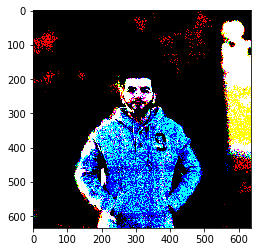

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [19]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

#### Content Cost

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [20]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [23]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [25]:
def model_nn(sess, input_image, num_iterations = 200):
    

    sess.run(tf.global_variables_initializer())

    sess.run(model["input"].assign(input_image))

    for i in range(num_iterations):

        sth = sess.run(train_step)
        generated_image = sess.run(model["input"])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [26]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 8495152000.0
content cost = 7647.3687
style cost = 212376900.0
Iteration 20 :
total cost = 1381997200.0
content cost = 19900.314
style cost = 34544950.0
Iteration 40 :
total cost = 428101570.0
content cost = 20913.41
style cost = 10697311.0
Iteration 60 :
total cost = 226493900.0
content cost = 21084.69
style cost = 5657076.5
Iteration 80 :
total cost = 146667570.0
content cost = 21079.61
style cost = 3661419.0
Iteration 100 :
total cost = 104152670.0
content cost = 21134.129
style cost = 2598533.2
Iteration 120 :
total cost = 78437860.0
content cost = 21190.86
style cost = 1955648.6
Iteration 140 :
total cost = 61668388.0
content cost = 21243.277
style cost = 1536398.9
Iteration 160 :
total cost = 50061652.0
content cost = 21296.701
style cost = 1246217.1
Iteration 180 :
total cost = 41641172.0
content cost = 21352.475
style cost = 1035691.2


array([[[[ 6.37778819e-01, -4.02295456e+01, -1.76597557e+01],
         [ 8.72341061e+00, -4.59436188e+01, -7.16912460e+01],
         [-2.75485096e+01, -3.30101852e+01, -9.60719833e+01],
         ...,
         [-1.42334869e+02,  1.47020829e+00,  2.64554577e+01],
         [-1.30815582e+02, -1.85331631e+01,  2.46577415e+01],
         [ 2.66479206e+01,  9.95998840e+01,  4.07113914e+01]],

        [[ 7.64481187e-01, -4.86589508e+01, -8.23721313e+01],
         [-1.20319347e+01, -3.05251694e+01, -2.34537373e+01],
         [ 1.40786469e+00,  1.61140114e-02,  8.28903008e+00],
         ...,
         [-1.19794304e+02, -7.93841019e+01,  2.74995708e+01],
         [-1.21613152e+02, -6.29253197e+01,  1.66665306e+01],
         [-1.21465998e+01,  1.60579620e+02,  4.77335739e+01]],

        [[-1.44893131e+01, -2.98298149e+01, -6.56766357e+01],
         [ 3.29073238e+00, -1.03093948e+01, -3.74103141e+00],
         [-1.29361563e+01,  5.48061714e+01,  2.78106823e+01],
         ...,
         [-1.05690826e+0

You're done! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

You should see something the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. After completing and submitting this assignment, we encourage you to come back and play more with this notebook, and see if you can generate even better looking images. 

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
